In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import Machine, generate_objects, BunchTracker, track, compare_traces
from test_tools import compare_projections, plot_debug_data

from PyHEADTAIL.feedback.feedback import OneboxFeedback, Kicker, PickUp
from PyHEADTAIL.feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL.feedback.processors.linear_transform import Averager
from PyHEADTAIL.feedback.processors.misc import Bypass
from PyHEADTAIL.feedback.processors.register import Register, TurnDelay
from PyHEADTAIL.feedback.processors.convolution import Lowpass, Gaussian, FIRFilter
from PyHEADTAIL.feedback.processors.addition import NoiseGenerator
np.random.seed(0)

PyHEADTAIL v1.13.0.21
(dirty git work tree)


--> Use the longitudinal_tracking module instead.

PyHEADTAIL_feedback v0.2




/home/lmether/Desktop/PyHEADTAIL_multibunch_merge/PyHEADTAIL_develop/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


# 004 Minimal intrabunch feedback model

In this test/example, a minimal model for an intrabunch feedback system is used.

## Basic parameters and elements for the simulations

In [2]:
n_macroparticles = 100000
n_slices = 50
n_segments = 5
n_sigma_z = 3
# n_sigma_z = 6

n_turns = 100

# Longitudinal motion of the bunch is not taken into account by default, but it can be included by uncommenting
# the line below
machine = Machine(n_segments= n_segments)
# machine = Machine(Q_s = 0.0020443)

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles, n_slices,n_sigma_z)

*** I am rank 0 - my buckets are [0]


## Initial bunch kick
Creates an artificially (slice-by-slice) kicked bunch, which will be damped by using different feedback implementations. 

In [3]:
N_knots = 4
amplitude = 1e-3 # [m]

temp_bunch = copy.deepcopy(bunch_ref)
temp_slicer = copy.deepcopy(slicer_ref)
slice_set = temp_bunch.get_slices(temp_slicer)

slicing_length = slice_set.z_bins[-1]-slice_set.z_bins[0]
wavelength = slicing_length/((N_knots+1.)/2.)
print 'slicing_length: ' + str(slicing_length)
print 'slicing_length in time: ' + str(slicing_length/c)

bunch_ref.x += amplitude*np.sin(2*np.pi*(bunch_ref.z-slice_set.z_bins[0])/wavelength)
bunch_ref.y += amplitude*np.sin(2*np.pi*(bunch_ref.z-slice_set.z_bins[0])/wavelength)

slicing_length: 0.6755906418658947
slicing_length in time: 2.2535278117833594e-09


## Feedback settings

In [4]:
feedback_gain = 0.1
# feedback_gain = (0.1,0.4)

# delay (a number of turns) before the pickup signal is used to the correction kick calculations.
delay = 1

# a number of values used to calculate the correct signal
n_values = 2

RMS_noise_level = 1e-6

# the cut off frequency of the bandwidth limitation
fc=1e10 

## Reference data
Tracks a bunch by using a charge weighted version of the ideal slice-by-slice feedback system presented in the first test (001_ideal_feedbacks.ipynb). The data are used as a reference data for the minimal intra bunch feedback model. 

In [5]:
# A reference feedback system, which is originally introduced in the file 001_ideal_feedbacks.ipynb:

bunch_ref_data = copy.deepcopy(bunch_ref)
tracker_ref_data = BunchTracker(bunch_ref_data)
slicer_ref_data = copy.deepcopy(slicer_ref)

processors_bunch_x = [
    ChargeWeighter()
]
processors_bunch_y = [
    ChargeWeighter()
]

feedback_map = OneboxFeedback(feedback_gain,slicer_ref_data,processors_bunch_x,processors_bunch_y)
one_turn_map = [i for i in trans_map] + [feedback_map] + [long_map]

track(n_turns, bunch_ref_data ,one_turn_map,tracker_ref_data)

## Minimal feedback model
The minimal feedback model includes the main elements of the feedback system, which might limit performance. Items for this model have chosen such a way that the modeled system should, in principle,  be possible to be built in real-life and any element of the model cause minimal disturbances and artifacts to simulation results. It is worth noting that the performance of the feedback system depends strongly on the details of the model.

The following signal processors have been chosen to the minimal model:

 * **Bypass(...)** - for monitoring the input signal
 
 * **ChargeWeighter(...)** - it was found that the charge weighted signal (i.e. 𝛥-signal from the pickup plate) is more stable in the simulations than the pure displacement signal (i.e. 𝛥/𝛴-signal from the pickup plates). This is because the stronger oscillations on the head/tail of the bunch together with the limited bandwidth might cause artificially strong kicks to the main, center, part of the bunch leading to instability growth if the "𝛥/𝛴-signal" is used. Note that the weighting is normalized to be one to the maximum charge, i.e. damping on the head/tail is reduced.
 
 * **Noise(...)** - Often it is argued that the pickup noise is the main noise source. In that case, noise must be added before the bandwidth limitation, which is often set by the used power amplifier and/or the kicker structure
 
 * **Gaussian(...)** - There are many ways to limit bandwidth, but a Gaussian filter is chosen for the minimal model.  The reasons for that are that, in principle, the frequency responses of the real systems can often be modified into Gaussian shape and a Gaussian filter is straightforward to the treat both in a time domain and in a frequency domain. It is worth noting that simulations results depend strongly on the chosen model for the bandwidth limitation. It is also important to keep in mind that the impulse response of the filter must be smooth in order to get reasonable results, e.g. the sharp peaks in the impulse responses of an RC filter and a phase linearized low pass filter cause of unrealistically good damping if a second cutoff frequency (smoothing) is not set correctly.
 
 * **TurnDelay(...)** - One turn delay between the pickup readings and the correction kicks can be implemented by using a *TurnDelay(...)*. The default correction algorithm is based on vector sum, which works well and can be also implemented in real systems. The correction algorithm type can be chosen the *combiner* parameter or giving FIR filter coefficients manually using a *TurnFIRFilter*-object.

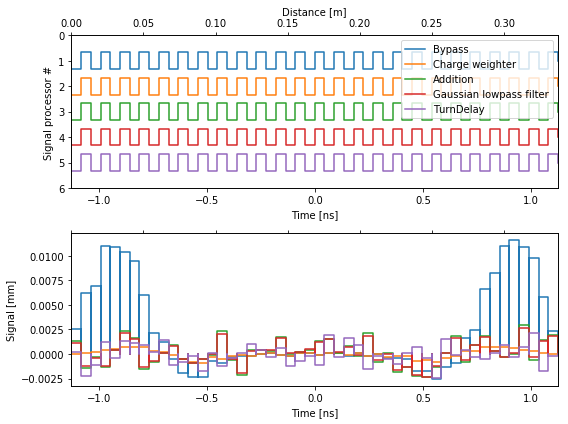

(<Figure size 576x432 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff720044510>)

In [6]:
bunch_minimal = copy.deepcopy(bunch_ref)
tracker_minimal = BunchTracker(bunch_minimal)
slicer_minimal = copy.deepcopy(slicer_ref)

processors_minimal_x = [
        Bypass(debug=True),
        ChargeWeighter(debug=True),
        NoiseGenerator(RMS_noise_level, debug=True),
        Gaussian(fc,debug=True),
        TurnDelay(delay, machine.Q_x, n_values,debug=True)
]

processors_minimal_y = [
        Bypass(),
        ChargeWeighter(),
        NoiseGenerator(RMS_noise_level),
        Gaussian(fc),
        TurnDelay(delay, machine.Q_x, n_values)
]


feedback_map = OneboxFeedback(feedback_gain,slicer_minimal,
                              processors_minimal_x, processors_minimal_y)
one_turn_map = [feedback_map] + [i for i in trans_map] # + [long_map]

track(n_turns, bunch_minimal,one_turn_map,tracker_minimal)
plot_debug_data(processors_minimal_x, source = 'output')

## Results comparison

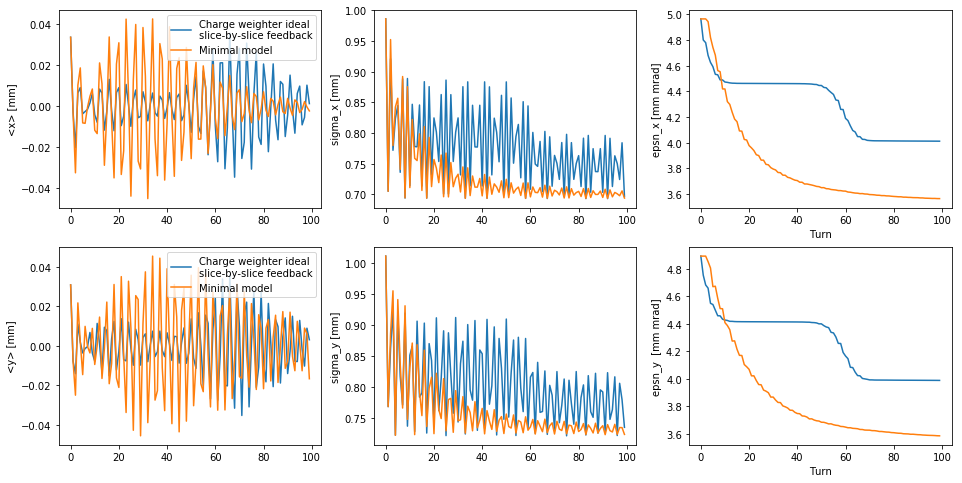

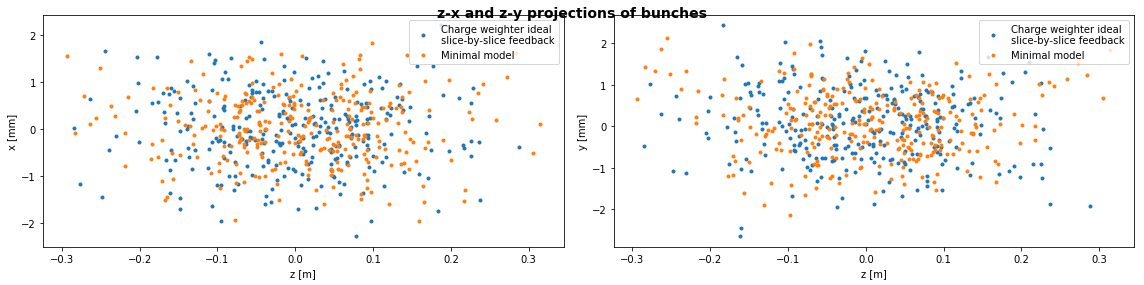

In [7]:
compare_traces([tracker_ref_data,tracker_minimal],
               ['Charge weighter ideal\nslice-by-slice feedback', 'Minimal model'])
compare_projections([ bunch_ref_data, bunch_minimal], 
               ['Charge weighter ideal\nslice-by-slice feedback', 'Minimal model'])

Jani Komppula, CERN, 2017